In [1]:
import os
from pathlib import Path
from functools import partial
from typing import cast

import torch
import matplotlib.pyplot as plt

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import ImagePreprocessing

DATASET_DIR = Path(os.environ["AD_DATASET_DIR"])
SAVED_MODEL = Path("..") / os.environ["SAVED_MODEL"]

In [2]:
create_ds = partial(
        MVTecAD,
        dataset_dir=Path(os.environ["AD_DATASET_DIR"]),
        object=os.environ["AD_OBJECT"],
        anomalies=["good"],
        sample_transform=ImagePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [3]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10816, out_features=256, bias=True)
    (10): ReLU()
  )
  (decoder): Decoder(
    (0): Linear(in_features=256, out_features=10816, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 13, 13))
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (8): ReLU()
    (9): ConvTranspose2d(8, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (10): ReLU()
  

Text(0.5, 1.0, 'Reconstructed')

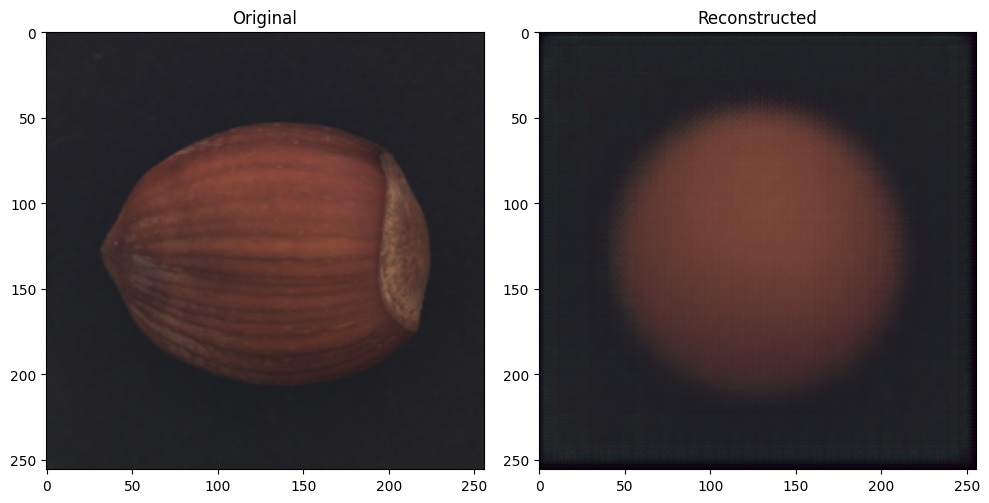

In [4]:
img_original, _ = cast(torch.Tensor, ds_train[2])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original.unsqueeze(dim=0))).squeeze()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
axs[0].imshow(img_original.movedim(0, -1))
axs[0].set_title("Original")
axs[1].imshow(img_reconstr.movedim(0, -1))
axs[1].set_title("Reconstructed")